# Bibliotecas

In [ ]:
# Bibliotecas de manipulação de dados
import numpy as np
import pandas as pd
import os

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Bibliotecas PyMOO
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Bibliotecas de Paralelização
from multiprocessing import Pool
from functools import partial

# Configurações

In [58]:
# Período de Teste
start_date = "2023-01-01"
end_date = "2023-12-31"

# Caminho arquivos com dados
close_price_file = "data/preco-ativos.csv"
selic_file = "data/SELIC.csv"

# Parâmetros do Algoritmo NSGA-II
max_weight = 0.10
pop_size = 250

# Parâmetros de Backtest
initial_value = 100000

# Dados

In [59]:
# Valores de fechamento e de retornos logaritmos diários
close_price_df = pd.read_csv(close_price_file, index_col=0, parse_dates=True)
daily_return_df = np.log(close_price_df / close_price_df.shift(1)).dropna()

# Valores da taxa selic para calcular sharpe
selic_df = pd.read_csv(selic_file, sep=";", parse_dates=["Date"], dayfirst=True, index_col="Date")
selic_df = selic_df[start_date:end_date]

# Datas de rebalanço e de cálculo do valor do portfólio
filtered_df = daily_return_df[start_date:end_date]
last_day_months = (filtered_df.groupby(filtered_df.index.to_period("M")).tail(1)).index
first_day_year = pd.Index([filtered_df.index[0]])
portfolio_dates = first_day_year.append(last_day_months)
rebalance_dates = portfolio_dates[:-1]

# Modelo

In [ ]:
class PortfolioProblem(ElementwiseProblem):
    """
    Definição do problema de otimização de portfólio com o NSGA-II.
    
    Minimiza o risco (variância) e maximiza o retorno esperado do portfólio,
    sujeito à restrição de peso máximo por ativo.
    
    Parameters:
    -----------
    mu : pd.Series or np.array
        Retornos esperados anualizados dos ativos
    cov : pd.DataFrame or np.array
        Matriz de covariância anualizada dos retornos
    max_weight : float, default=0.10
        Peso máximo permitido para cada ativo (em decimal, ex: 0.10 = 10%)
    **kwargs : dict
        Argumentos adicionais para a classe ElementwiseProblem
        
    Attributes:
    -----------
    n_assets : int
        Número de ativos no universo de investimento
    max_weight : float
        Restrição de peso máximo por ativo
    mu : array-like
        Vetor de retornos esperados
    cov : array-like
        Matriz de covariância dos retornos
    """
    
    def __init__(self, mu, cov, max_weight=0.10, **kwargs):
        self.n_assets = len(mu)
        self.max_weight = max_weight
        
        # Definir problema: n_var ativos, 2 objetivos, n_assets restrições
        super().__init__(n_var=self.n_assets, n_obj=2, n_constr=self.n_assets, 
                        xl=0.0, xu=1.0, **kwargs)

        self.mu = mu
        self.cov = cov

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Avalia os objetivos e restrições para uma solução de portfólio.
        
        Parameters:
        -----------
        x : np.array
            Vetor de pesos do portfólio (antes da normalização)
        out : dict
            Dicionário de saída contendo objetivos (F) e restrições (G)
        """
        # Objetivo 1: Minimizar risco (variância do portfólio)
        # Objetivo 2: Maximizar retorno (minimizar -retorno)
        expected_return = self.mu.T @ x
        risk = x.T @ self.cov @ x
        out["F"] = [risk, -expected_return]

        # Restrição: peso de cada ativo <= max_weight
        g1 = x - self.max_weight
        out["G"] = g1


class SumToOneRepair(Repair):
    """
    Operador de reparo que normaliza os pesos do portfólio para somar 1.
    
    Garante que a restrição de orçamento (soma dos pesos = 100%) seja sempre atendida,
    normalizando os pesos pela sua soma total.
    """
    
    def _do(self, problem, X, **kwargs):
        """
        Aplica a normalização aos pesos do portfólio.
        
        Parameters:
        -----------
        problem : PortfolioProblem
            Instância do problema de otimização
        X : np.array
            Matriz de soluções (população x variáveis)
            
        Returns:
        --------
        np.array
            Matriz de soluções normalizadas
        """
        return X / np.sum(X, axis=1, keepdims=True)

# Otimização

In [ ]:
def portfolio_optimize(daily_return_df, rebalance_dates, max_weight, pop_size):
    """
    Otimiza portfólios usando NSGA-II para múltiples períodos de rebalanceamento.
    
    Para cada data de rebalanceamento, utiliza janela móvel de 252 dias (1 ano)
    de retornos históricos para estimar parâmetros e otimizar o portfólio.
    
    Parameters:
    -----------
    daily_return_df : pd.DataFrame
        DataFrame com retornos logarítmicos diários dos ativos
    rebalance_dates : pd.Index
        Datas de rebalanceamento do portfólio
    max_weight : float
        Peso máximo permitido por ativo (ex: 0.10 = 10%)
    pop_size : int
        Tamanho da população do algoritmo NSGA-II
        
    Returns:
    --------
    tuple
        (pareto_fronts, pareto_weights) - Lista das fronteiras de Pareto e
        pesos dos portfólios ótimos para cada período
        
    Notes:
    ------
    - Utiliza janela móvel de 252 dias úteis (aproximadamente 1 ano)
    - Retornos e covariância são anualizados (multiplicados por 252)
    - Algoritmo executado com 500 gerações e semente fixa para reprodutibilidade
    """
    pareto_fronts = []
    pareto_weights = []

    for i in range(len(rebalance_dates)):
        period_start = rebalance_dates[i]
        
        # Janela móvel de 252 dias (aproximadametne 1 ano) para estimação de parâmetros
        log_returns = daily_return_df.loc[:period_start].iloc[-252:]
        
        if log_returns.empty:
            continue
            
        # Anualizar retornos esperados e matriz de covariância
        mu = log_returns.mean() * 252
        cov = log_returns.cov() * 252

        # Configurar problema de otimização
        problem = PortfolioProblem(mu, cov, max_weight)
        
        # Configurar algoritmo NSGA-II
        algorithm = NSGA2(
            pop_size=pop_size,
            repair=SumToOneRepair(),
            crossover=SBX(prob=0.9, eta=20.0),    # Crossover simulado
            mutation=PM(prob=1.0 / problem.n_var, eta=20.0)  # Mutação polinomial
        )
        
        # Critério de parada
        termination = get_termination("n_gen", 500)
        
        # Executar otimização
        res = minimize(problem, algorithm, termination, seed=1, verbose=False)

        pareto_fronts.append(res.F)
        pareto_weights.append(res.X)

    return pareto_fronts, pareto_weights

In [ ]:
pareto_fronts, pareto_weights = portfolio_optimize(daily_return_df,
                                                   rebalance_dates,
                                                   max_weight,
                                                   pop_size)

# BACKTEST

## Maior sharpe

In [62]:
def get_all_max_sharpe_portfolios(pareto_weights, pareto_fronts, rebalance_dates, selic_df):
    """
    Seleciona o portfólio com maior Índice de Sharpe de cada fronteira de Pareto.
    
    Para cada período de rebalanceamento, calcula o Índice de Sharpe usando a taxa
    SELIC como taxa livre de risco e seleciona o portfólio ótimo.
    
    Parameters:
    -----------
    pareto_weights : list
        Lista de arrays com pesos dos portfólios da fronteira de Pareto
    pareto_fronts : list
        Lista de arrays com objetivos (risco, -retorno) dos portfólios
    rebalance_dates : pd.Index
        Datas de rebalanceamento do portfólio
    selic_df : pd.DataFrame
        DataFrame com taxas SELIC históricas (coluna 'Taxa' em %)
        
    Returns:
    --------
    tuple
        (all_weights, all_sharpe_ratios, valid_dates) - Pesos dos portfólios
        selecionados, seus respectivos Índices de Sharpe e datas válidas
        
    Notes:
    ------
    - Taxa SELIC é interpolada para datas não disponíveis
    - Taxa padrão de 2% é usada se nenhuma taxa histórica estiver disponível
    - Imprime progresso com data, Sharpe e taxa livre de risco para cada período
    """
    all_weights = []
    all_sharpe_ratios = []
    valid_dates = []
    
    for i in range(len(pareto_fronts)):
        date = rebalance_dates[i]
        
        # Obter taxa livre de risco (SELIC) para a data
        if date in selic_df.index:
            risk_free_rate = selic_df.loc[date, 'Taxa'] / 100
        else:
            # Interpolação: usar última taxa disponível antes da data
            available_dates = selic_df.index[selic_df.index <= date]
            if len(available_dates) > 0:
                closest_date = available_dates[-1]
                risk_free_rate = selic_df.loc[closest_date, 'Taxa'] / 100
            else:
                # Taxa padrão se não houver dados históricos
                risk_free_rate = 0.02
        
        # Extrair dados da fronteira de Pareto
        front = pareto_fronts[i]
        weights = pareto_weights[i]
        
        # Converter objetivos para retorno e risco
        expected_returns = -front[:, 1]  # Reverter sinal negativo
        risks = np.sqrt(front[:, 0])     # Desvio padrão
        
        # Calcular Índice de Sharpe para todos os portfólios
        sharpe_ratios = (expected_returns - risk_free_rate) / risks
        
        # Selecionar portfólio com maior Sharpe
        max_sharpe_idx = np.argmax(sharpe_ratios)
        best_weights = weights[max_sharpe_idx]
        best_sharpe = sharpe_ratios[max_sharpe_idx]
        
        all_weights.append(best_weights)
        all_sharpe_ratios.append(best_sharpe)
        valid_dates.append(date)
        
        print(f"Data: {date.strftime('%Y-%m-%d')} | Sharpe: {best_sharpe:.4f} | Risk-free: {risk_free_rate:.4f}")
    
    return all_weights, all_sharpe_ratios, valid_dates


all_weights, all_sharpe_ratios, valid_dates = get_all_max_sharpe_portfolios(
    pareto_weights, pareto_fronts, rebalance_dates, selic_df
)

print(f"\nNúmero de portfólios otimizados: {len(all_weights)}")
print(f"Sharpe Ratio médio: {np.mean(all_sharpe_ratios):.4f}")
print(f"Melhor Sharpe Ratio: {np.max(all_sharpe_ratios):.4f}")

Data: 2023-01-02 | Sharpe: 0.6026 | Risk-free: 0.1365
Data: 2023-01-31 | Sharpe: 0.7879 | Risk-free: 0.1365
Data: 2023-02-28 | Sharpe: 0.3407 | Risk-free: 0.1365
Data: 2023-03-31 | Sharpe: 0.1070 | Risk-free: 0.1365
Data: 2023-04-28 | Sharpe: 0.4959 | Risk-free: 0.1365
Data: 2023-05-31 | Sharpe: 0.5661 | Risk-free: 0.1365
Data: 2023-06-30 | Sharpe: 1.3595 | Risk-free: 0.1365
Data: 2023-07-31 | Sharpe: 1.4678 | Risk-free: 0.1365
Data: 2023-08-31 | Sharpe: 0.9844 | Risk-free: 0.1315
Data: 2023-09-29 | Sharpe: 1.2170 | Risk-free: 0.1265
Data: 2023-10-31 | Sharpe: 1.0790 | Risk-free: 0.1265
Data: 2023-11-30 | Sharpe: 2.3102 | Risk-free: 0.1215

Número de portfólios otimizados: 12
Sharpe Ratio médio: 0.9432
Melhor Sharpe Ratio: 2.3102


## Backtest

In [ ]:
def monthly_backtest(all_weights, portfolio_dates, close_price_df, initial_value=100000):
    """
    Executa backtest do portfólio otimizado e calcula evolução do patrimônio.
    
    Simula a estratégia de investimento rebalanceando mensalmente conforme
    os pesos otimizados e calcula o valor do portfólio ao longo do tempo.
    
    Parameters:
    -----------
    all_weights : list
        Lista de arrays com pesos otimizados para cada período
    portfolio_dates : pd.Index
        Datas de avaliação do portfólio (rebalanceamento + data final)
    close_price_df : pd.DataFrame
        DataFrame com preços de fechamento dos ativos
    initial_value : float, default=100000
        Valor inicial do investimento em reais
        
    Returns:
    --------
    list
        Lista com valores do portfólio em cada data de avaliação
        
    Notes:
    ------
    - Assume rebalanceamento no início de cada período
    - Calcula retornos simples dos ativos entre datas consecutivas
    - Imprime retorno do portfólio para cada período
    - Não considera custos de transação
    """
    portfolio_values = [initial_value]
    portfolio_value = initial_value
    
    print("=== BACKTEST ===")
    
    for i in range(len(all_weights)):
        current_date = portfolio_dates[i]
        next_date = portfolio_dates[i+1]
        weights = all_weights[i]
        
        # Obter preços no início e fim do período
        current_prices = close_price_df.loc[current_date]
        next_prices = close_price_df.loc[next_date]
        
        # Calcular retornos simples dos ativos
        asset_returns = (next_prices / current_prices) - 1
        
        # Calcular retorno ponderado do portfólio
        portfolio_return = np.sum(weights * asset_returns)
        
        # Atualizar valor do portfólio
        portfolio_value *= (1 + portfolio_return)
        portfolio_values.append(portfolio_value)
        
        print(f"{current_date.strftime("%Y-%m-%d")} -> {next_date.strftime("%Y-%m-%d")}: {portfolio_return:.2%}")
    
    return portfolio_values

portfolio_values = monthly_backtest(all_weights, portfolio_dates, close_price_df, initial_value)

=== BACKTEST ===
2023-01-02 -> 2023-01-31: 5.49%
2023-01-31 -> 2023-02-28: -4.45%
2023-02-28 -> 2023-03-31: -1.19%
2023-03-31 -> 2023-04-28: 2.37%
2023-04-28 -> 2023-05-31: 0.88%
2023-05-31 -> 2023-06-30: 2.27%
2023-06-30 -> 2023-07-31: 3.50%
2023-07-31 -> 2023-08-31: -3.51%
2023-08-31 -> 2023-09-29: -1.08%
2023-09-29 -> 2023-10-31: 2.80%
2023-10-31 -> 2023-11-30: 5.11%
2023-11-30 -> 2023-12-28: 4.90%


## Métricas de Performance

In [47]:
def calculate_portfolio_metrics(portfolio_values, portfolio_dates, risk_free_rate=0.02):
    """
    Calcula métricas de performance do portfólio.
    
    Parameters:
    -----------
    portfolio_values : list
        Lista com valores do portfólio em cada data de avaliação
    portfolio_dates : pd.Index
        Datas de avaliação do portfólio
    risk_free_rate : float, default=0.02
        Taxa livre de risco anual (2% como padrão)
        
    Returns:
    --------
    dict
        Dicionário com as métricas calculadas
    """
    # Converter para Series para facilitar cálculos
    portfolio_series = pd.Series(portfolio_values, index=portfolio_dates)
    
    # Calcular retornos simples
    returns = portfolio_series.pct_change().dropna()
    
    # Retorno anualizado
    total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    n_years = (portfolio_dates[-1] - portfolio_dates[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1/n_years) - 1
    
    # Volatilidade anualizada
    annualized_volatility = returns.std() * np.sqrt(12)  # 12 meses por ano
    
    # Índice de Sharpe anual
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # Maximum Drawdown
    peak = portfolio_series.cummax()
    drawdown = (portfolio_series - peak) / peak
    max_drawdown = drawdown.min()
    
    return {
        'retorno_anualizado': annualized_return,
        'volatilidade_anualizada': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'valor_final': portfolio_values[-1],
        'retorno_total': total_return
    }

# Calcular métricas
selic_media = (selic_df.mean() / 100).iloc[0]
metrics = calculate_portfolio_metrics(portfolio_values, portfolio_dates, risk_free_rate=selic_media)

# Exibir resultados
print("=== MÉTRICAS DE PERFORMANCE ===")
print(f"Retorno anualizado: {metrics['retorno_anualizado']:.2%}")
print(f"Volatilidade anualizada: {metrics['volatilidade_anualizada']:.2%}")
print(f"Índice de Sharpe: {metrics['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {metrics['max_drawdown']:.2%}")
print(f"Valor final do portfólio: R$ {metrics['valor_final']:,.2f}")
print(f"Retorno total: {metrics['retorno_total']:.2%}")

=== MÉTRICAS DE PERFORMANCE ===
Retorno anualizado: 18.07%
Volatilidade anualizada: 11.55%
Índice de Sharpe: 0.42
Maximum Drawdown: -5.58%
Valor final do portfólio: R$ 117,791.28
Retorno total: 17.79%


# Análise dos resultados

## Evolução do portfólio ao longo do tempo

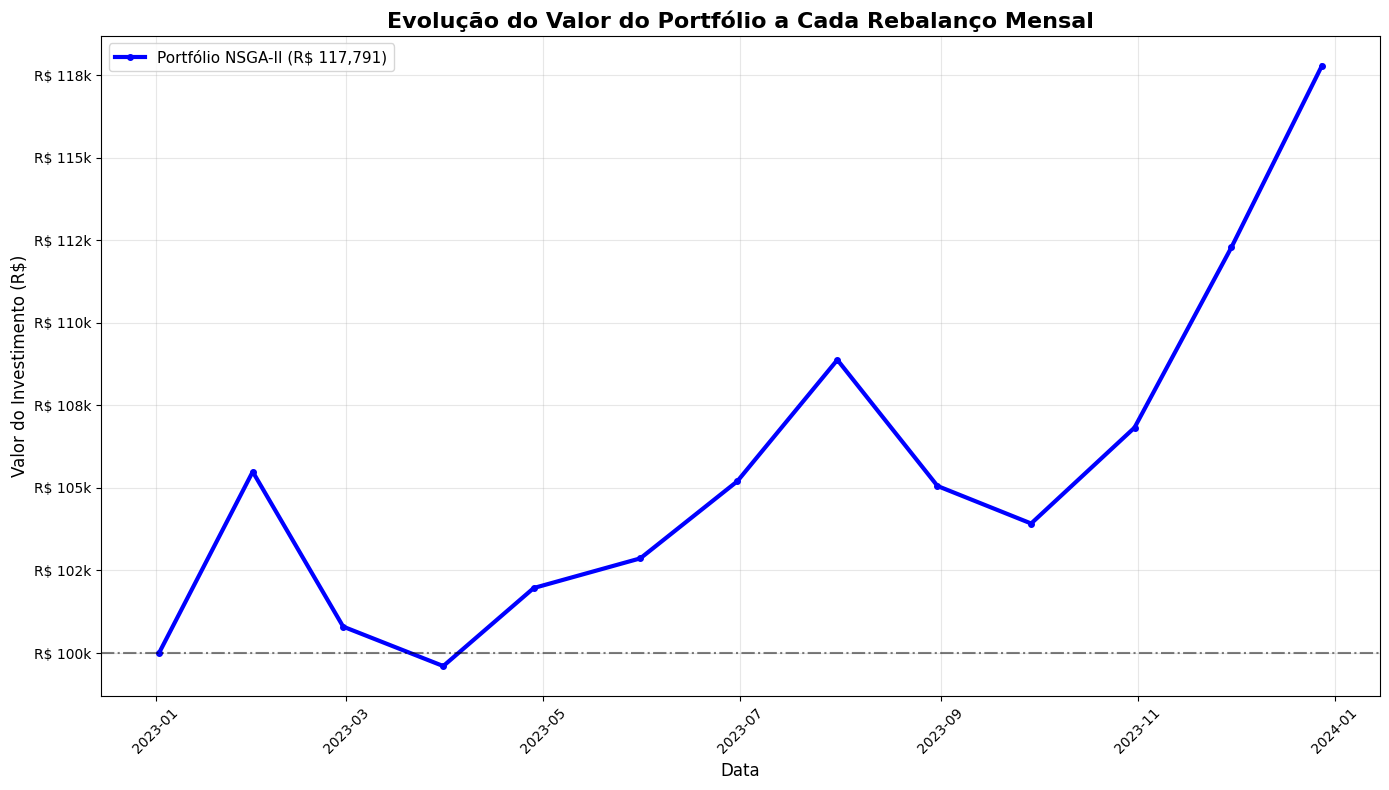


=== RESULTADOS COMPARATIVOS ===
NSGA-II:      R$ 117,791.28 ( 17.79%)


In [ ]:
def plot_portfolio_evolution(portfolio_values, portfolio_dates):
    """
    Plota a evolução temporal do valor do portfólio otimizado.
    
    Cria gráfico de linha mostrando como o valor do investimento evoluiu
    ao longo do tempo com os rebalanceamentos mensais.
    
    Parameters:
    -----------
    portfolio_values : list
        Lista com valores do portfólio em cada data de avaliação
    portfolio_dates : pd.Index
        Datas de avaliação do portfólio
        
    Notes:
    ------
    - Formata eixo Y em milhares de reais (k)
    - Formata eixo X com datas bimestrais
    - Adiciona linha de referência do valor inicial
    - Calcula e exibe retorno total do período
    """
    # Criar figura com tamanho adequado
    plt.figure(figsize=(14, 8))
    
    # Plotar evolução do portfólio NSGA-II
    plt.plot(portfolio_dates, portfolio_values, 
             linewidth=3, 
             label=f"Portfólio NSGA-II (R$ {portfolio_values[-1]:,.0f})", 
             color="blue", 
             marker="o", 
             markersize=4)
    
    # Configuração do título e rótulos
    plt.title("Evolução do Valor do Portfólio a Cada Rebalanço Mensal", 
              fontsize=16, fontweight="bold")
    plt.xlabel("Data", fontsize=12)
    plt.ylabel("Valor do Investimento (R$)", fontsize=12)
    
    # Formatação do eixo Y (valores em milhares)
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, p: f"R$ {x/1000:.0f}k")
    )
    
    # Formatação do eixo X (datas bimestrais)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)
    
    # Grid e legenda
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11, loc="upper left")
    
    # Linha de referência do valor inicial
    plt.axhline(y=initial_value, color="black", linestyle="-.", alpha=0.5, 
                label=f"Valor Inicial (R$ {initial_value:,.0f})")
    
    plt.tight_layout()
    plt.show()
    
    # Calcular e exibir métricas de performance
    total_return_nsga = (portfolio_values[-1] / portfolio_values[0]) - 1
    
    print("\n=== RESULTADOS COMPARATIVOS ===")
    print(f"NSGA-II:      R$ {portfolio_values[-1]:>10,.2f} ({total_return_nsga:>7.2%})")

plot_portfolio_evolution(portfolio_values, portfolio_dates)

## Composição do portfólio ao longo do tempo

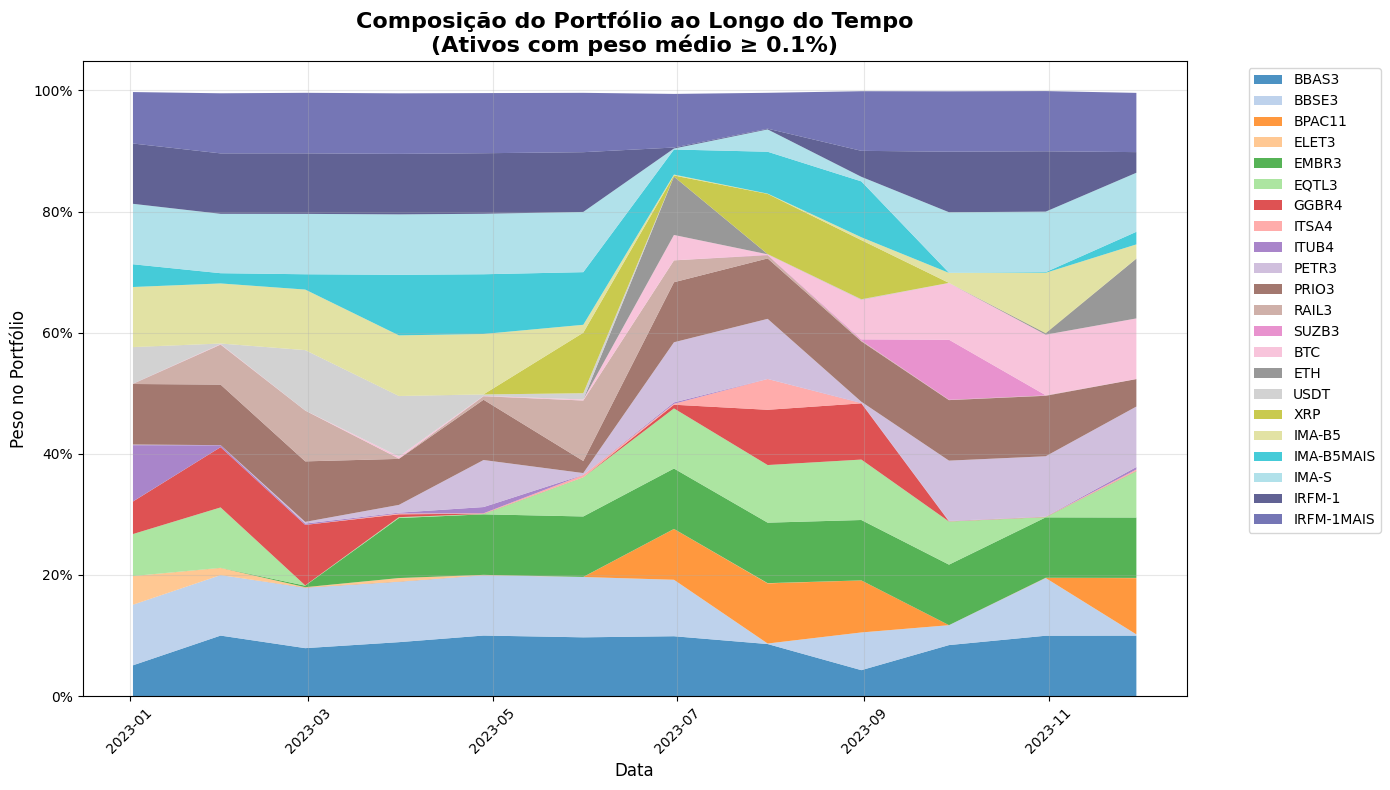


=== TOP 10 ATIVOS POR PESO MÉDIO ===
 1. IRFM-1MAIS: 9.37%
 2. PRIO3: 8.66%
 3. BBAS3: 8.56%
 4. IMA-S: 7.83%
 5. EMBR3: 7.50%
 6. BBSE3: 7.38%
 7. IRFM-1: 7.31%
 8. EQTL3: 5.66%
 9. IMA-B5: 5.47%
10. PETR3: 4.97%

Resumo:
Ativos com peso ≥ 0.1%: 22
Peso médio máximo: 9.37% (IRFM-1MAIS)
Peso médio dos top 10: 7.27%


In [ ]:
def plot_portfolio_composition(all_weights, rebalance_dates, close_price_df, 
                             min_avg_weight=0.01, top_n_assets=10, figsize=(14, 8)):
    """
    Plota a composição do portfólio ao longo do tempo usando gráfico de área empilhada.
    
    Parameters:
    -----------
    all_weights : list
        Lista de arrays contendo os pesos dos ativos para cada período de rebalanceamento
    rebalance_dates : pd.Index
        Datas de rebalanceamento do portfólio
    close_price_df : pd.DataFrame
        DataFrame com preços de fechamento dos ativos
    min_avg_weight : float, default=0.01
        Peso médio mínimo para um ativo ser considerado significativo (em decimal, ex: 0.01 = 1%)
    top_n_assets : int, default=10
        Número de principais ativos a exibir no ranking
    figsize : tuple, default=(14, 8)
        Tamanho da figura (largura, altura)
        
    Returns:
    --------
    tuple
        (weights_df, significant_assets, avg_weights) - DataFrame dos pesos, 
        ativos significativos e pesos médios
    """
    
    # Validação de entrada
    if not all_weights:
        raise ValueError("Lista de pesos não pode estar vazia")
    if len(all_weights) > len(rebalance_dates):
        raise ValueError("Número de pesos excede número de datas de rebalanceamento")
    
    # Criar DataFrame com os pesos
    tickers = close_price_df.columns.tolist()
    valid_weights = all_weights[:len(rebalance_dates)]
    weights_df = pd.DataFrame(valid_weights, columns=tickers, 
                             index=rebalance_dates[:len(valid_weights)])
    
    # Filtrar ativos significativos
    avg_weights = weights_df.mean()
    significant_assets = avg_weights[avg_weights >= min_avg_weight].index
    
    if len(significant_assets) == 0:
        print(f"Aviso: Nenhum ativo encontrado com peso médio >= {min_avg_weight:.1%}")
        significant_assets = avg_weights.nlargest(min(5, len(avg_weights))).index
        print(f"Usando os {len(significant_assets)} maiores ativos por peso médio")
    
    # Configurar gráfico
    fig, ax = plt.subplots(figsize=figsize)
    
    # Gerar cores para os ativos
    colors = _generate_colors(len(significant_assets))
    
    # Dados para o gráfico empilhado
    weights_significant = weights_df[significant_assets]
    
    # Criar gráfico de área empilhada
    ax.stackplot(weights_df.index, 
                *[weights_significant[col] for col in significant_assets],
                labels=significant_assets,
                colors=colors,
                alpha=0.8)
    
    # Formatação do gráfico
    _format_plot(ax, min_avg_weight)
    
    plt.tight_layout()
    plt.show()
    
    # Exibir estatísticas
    _print_portfolio_statistics(avg_weights, top_n_assets, min_avg_weight)
    
    return weights_df, significant_assets, avg_weights


def _generate_colors(num_colors):
    """
    Gera uma paleta de cores combinando tab20 e tab20b para visualização.
    
    Parameters:
    -----------
    num_colors : int
        Número de cores necessárias
        
    Returns:
    --------
    np.array
        Array de cores RGBA
    """
    colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
    colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
    all_colors = np.vstack((colors1, colors2))
    
    # Retorna apenas o número necessário de cores
    return all_colors[:num_colors]


def _format_plot(ax, min_avg_weight):
    """
    Aplica formatação padrão ao gráfico de composição do portfólio.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Eixo do matplotlib para formatação
    min_avg_weight : float
        Peso mínimo usado para filtrar ativos (usado no título)
    """
    ax.set_title(f"Composição do Portfólio ao Longo do Tempo\n"
                f"(Ativos com peso médio ≥ {min_avg_weight:.1%})", 
                fontsize=16, fontweight="bold")
    ax.set_xlabel("Data", fontsize=12)
    ax.set_ylabel("Peso no Portfólio", fontsize=12)
    
    # Formatação dos eixos
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
    ax.tick_params(axis="x", rotation=45)
    
    # Grid e legenda
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)


def _print_portfolio_statistics(avg_weights, top_n_assets, min_avg_weight):
    """
    Imprime estatísticas dos pesos do portfólio.
    
    Parameters:
    -----------
    avg_weights : pd.Series
        Pesos médios dos ativos
    top_n_assets : int
        Número de principais ativos a exibir
    min_avg_weight : float
        Peso mínimo para considerar ativo significativo
    """
    print(f"\n=== TOP {top_n_assets} ATIVOS POR PESO MÉDIO ===")
    top_assets = avg_weights.sort_values(ascending=False).head(top_n_assets)
    
    for i, (asset, weight) in enumerate(top_assets.items(), 1):
        print(f"{i:2d}. {asset}: {weight:.2%}")
    
    # Estatísticas adicionais
    total_significant = (avg_weights >= min_avg_weight).sum()
    print(f"\nResumo:")
    print(f"Ativos com peso ≥ {min_avg_weight:.1%}: {total_significant}")
    print(f"Peso médio máximo: {avg_weights.max():.2%} ({avg_weights.idxmax()})")
    print(f"Peso médio dos top {top_n_assets}: {top_assets.mean():.2%}")


# Plotar composição com parâmetros personalizáveis
weights_df, significant_assets, avg_weights = plot_portfolio_composition(
    all_weights, rebalance_dates, close_price_df, 
    min_avg_weight=0.001,
    top_n_assets=10
)